In [68]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from pprint import pprint
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

In [69]:
def prepare_kijkcijfers():
    start_date = datetime(2025, 5, 1)
    end_date = datetime.today()

    all_records = []

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        
        url = f"https://api.cim.be/api/cim_tv_public_results_daily_views?dateDiff={date_str}&reportType=north"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            
            data = response.json()
            records = data.get('hydra:member', [])
            
            all_records.extend(records)
        
        except Exception as e:
            print(f"Failed for date {date_str}: {e}")
        
        current_date += timedelta(days=1)

    df = pd.DataFrame(all_records)

    df['dateResult'] = pd.to_datetime(df['dateResult'])
    df['weekday'] = df['dateResult'].dt.weekday
    df['day'] = df['dateResult'].dt.day
    df['month'] = df['dateResult'].dt.month
    df['year'] = df['dateResult'].dt.year

    df['startTime'] = pd.to_datetime(df['startTime'], format='%H:%M:%S', errors='coerce')
    df['start_hour'] = df['startTime'].dt.hour
    df['start_minute'] = df['startTime'].dt.minute

    df['rLength'] = pd.to_timedelta(df['rLength'], errors='coerce')
    df['duration_seconds'] = df['rLength'].dt.total_seconds()

    df = df.drop(columns=['@id', '@type', 'reportType', 'id', 'dateImport', 'category', 'ratePerc', 'shr','rateInKAll', 'dateDiff', 'dateResult', 'startTime', 'rLength'])

    df.dropna(inplace=True)


    return df

kijkcijfers = prepare_kijkcijfers()
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           499 non-null    object 
 1   description       499 non-null    object 
 2   channel           499 non-null    object 
 3   rateInK           499 non-null    object 
 4   live              499 non-null    int64  
 5   weekday           499 non-null    int32  
 6   day               499 non-null    int32  
 7   month             499 non-null    int32  
 8   year              499 non-null    int32  
 9   start_hour        499 non-null    float64
 10  start_minute      499 non-null    float64
 11  duration_seconds  499 non-null    float64
dtypes: float64(3), int32(4), int64(1), object(4)
memory usage: 42.9+ KB


In [70]:
kijkcijfers2 = kijkcijfers

In [71]:
kijkcijfers['rateInK'] = pd.to_numeric(
    kijkcijfers['rateInK']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False),
    errors='coerce'  # Invalid values become NaN
)

In [72]:
kijkcijfers['channel'] = kijkcijfers['channel'].astype("string")
kijkcijfers['description'] = kijkcijfers['description'].astype("string")

In [73]:
kijkcijfers['ranking'] = kijkcijfers['ranking'].astype(int)

In [74]:
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           499 non-null    int64  
 1   description       499 non-null    string 
 2   channel           499 non-null    string 
 3   rateInK           499 non-null    int64  
 4   live              499 non-null    int64  
 5   weekday           499 non-null    int32  
 6   day               499 non-null    int32  
 7   month             499 non-null    int32  
 8   year              499 non-null    int32  
 9   start_hour        499 non-null    float64
 10  start_minute      499 non-null    float64
 11  duration_seconds  499 non-null    float64
dtypes: float64(3), int32(4), int64(3), string(2)
memory usage: 42.9 KB


In [75]:
kijkcijfers = kijkcijfers[kijkcijfers['rateInK'].notna()]
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           499 non-null    int64  
 1   description       499 non-null    string 
 2   channel           499 non-null    string 
 3   rateInK           499 non-null    int64  
 4   live              499 non-null    int64  
 5   weekday           499 non-null    int32  
 6   day               499 non-null    int32  
 7   month             499 non-null    int32  
 8   year              499 non-null    int32  
 9   start_hour        499 non-null    float64
 10  start_minute      499 non-null    float64
 11  duration_seconds  499 non-null    float64
dtypes: float64(3), int32(4), int64(3), string(2)
memory usage: 42.9 KB


In [76]:
kijkcijfers.head(30)

,ranking,description,channel,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
0,1,THUIS,VRT 1,923377,7,3,1,5,2025,20.0,7.0,1469.0
1,2,HET 7 UUR-JOURNAAL,VRT 1,666184,7,3,1,5,2025,19.0,0.0,2345.0
2,3,HUIS GEMAAKT,VTM,605254,7,3,1,5,2025,20.0,40.0,3595.0
3,4,FAMILIE,VTM,503557,7,3,1,5,2025,20.0,5.0,1496.0
4,5,IEDEREEN BEROEMD,VRT 1,499720,7,3,1,5,2025,19.0,41.0,1074.0
5,6,WONDER BOVEN WONDER,VRT 1,474594,7,3,1,5,2025,20.0,33.0,2753.0
6,7,BLOKKEN,VRT 1,427712,7,3,1,5,2025,18.0,29.0,1685.0
7,8,NIEUWS 19U VTM,VTM,416031,7,3,1,5,2025,18.0,59.0,3203.0
8,9,KAMP JEROOM,PLAY4,395404,7,3,1,5,2025,21.0,20.0,2524.0
9,10,HET 1 UUR-JOURNAAL,VRT 1,379379,7,3,1,5,2025,13.0,0.0,1681.0


In [77]:
kijkcijfers.describe()

,ranking,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
count,499.000000,4.990000e+02,499.000000,499.000000,499.000000,499.0,499.0,499.000000,499.000000,499.000000
mean,10.503006,3.623556e+05,5.036072,3.236473,12.991984,5.0,2025.0,18.687375,28.128257,2761.805611
std,5.777457,2.217492e+05,3.148070,1.967658,7.223340,0.0,0.0,2.895513,20.306872,2012.132777
min,1.000000,8.111500e+04,0.000000,0.000000,1.000000,5.0,2025.0,11.000000,0.000000,909.000000
25%,5.500000,1.889185e+05,0.000000,2.000000,7.000000,5.0,2025.0,18.000000,10.000000,1562.000000
50%,11.000000,2.767020e+05,7.000000,3.000000,13.000000,5.0,2025.0,20.000000,28.000000,2516.000000
75%,15.500000,5.136165e+05,7.000000,5.000000,19.000000,5.0,2025.0,20.500000,45.000000,3138.000000
max,20.000000,1.231752e+06,7.000000,6.000000,25.000000,5.0,2025.0,23.000000,59.000000,17292.000000


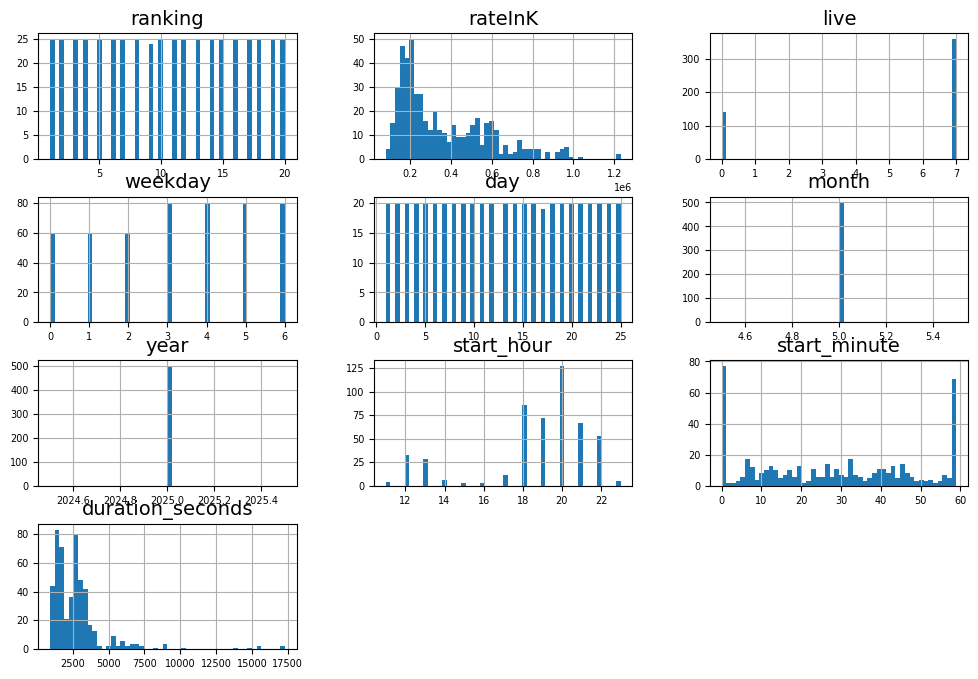

In [78]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

kijkcijfers.hist(bins=50, figsize=(12, 8))
plt.show()

In [79]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(kijkcijfers, test_size=0.2, random_state=42)

In [80]:
len(train_set)

399

In [81]:
len(test_set)

100

In [82]:
train_set.head()

,ranking,description,channel,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
56,17,"ONS HUIS, NIEUW HUIS",VRT 1,150033,7,5,3,5,2025,22.0,41.0,3746.0
227,8,BLOKKEN,VRT 1,527734,7,0,12,5,2025,18.0,28.0,1710.0
280,1,THUIS,VRT 1,953238,7,3,15,5,2025,20.0,18.0,1395.0
487,8,DE NOODCENTRALE,VRT 1,269236,0,6,25,5,2025,21.0,38.0,2307.0
220,1,THUIS,VRT 1,938147,7,0,12,5,2025,20.0,12.0,1491.0


In [83]:
kijkcijfers = train_set.copy()

In [84]:
corr_matrix = kijkcijfers.corr(numeric_only=True)

In [85]:
corr_matrix["rateInK"].sort_values(ascending=False)

rateInK             1.000000
start_hour          0.147773
live                0.092458
duration_seconds   -0.086529
weekday            -0.088686
day                -0.094082
start_minute       -0.184372
ranking            -0.885353
month                    NaN
year                     NaN
Name: rateInK, dtype: float64

In [86]:
corr_matrix

,ranking,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
ranking,1.000000,-0.885353,-0.014698,-0.041056,0.040146,NaN,NaN,-0.096198,0.109975,0.100480
rateInK,-0.885353,1.000000,0.092458,-0.088686,-0.094082,NaN,NaN,0.147773,-0.184372,-0.086529
live,-0.014698,0.092458,1.000000,0.107785,-0.777631,NaN,NaN,-0.017629,0.008719,0.041676
weekday,-0.041056,-0.088686,0.107785,1.000000,0.049770,NaN,NaN,-0.074161,-0.009328,0.165261
day,0.040146,-0.094082,-0.777631,0.049770,1.000000,NaN,NaN,-0.000241,-0.023492,0.034832
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_hour,-0.096198,0.147773,-0.017629,-0.074161,-0.000241,NaN,NaN,1.000000,-0.059834,-0.074020
start_minute,0.109975,-0.184372,0.008719,-0.009328,-0.023492,NaN,NaN,-0.059834,1.000000,0.072590
duration_seconds,0.100480,-0.086529,0.041676,0.165261,0.034832,NaN,NaN,-0.074020,0.072590,1.000000


In [87]:
kijkcijfers = train_set.drop("rateInK", axis=1)
kijkcijfers_labels = train_set["rateInK"].copy()

In [88]:
X_test = test_set.drop("rateInK", axis=1)
y_test = test_set["rateInK"].copy()

In [89]:
channel_cat = kijkcijfers[["channel"]]
channel_cat.head(10)

,channel
56,VRT 1
227,VRT 1
280,VRT 1
487,VRT 1
220,VRT 1
449,VRT 1
423,VTM
377,VRT CANVAS
25,VTM
229,VRT 1


In [90]:
description_cat = kijkcijfers[["description"]]
description_cat.head(10)

,description
56,"ONS HUIS, NIEUW HUIS"
227,BLOKKEN
280,THUIS
487,DE NOODCENTRALE
220,THUIS
449,DAGELIJKSE KOST
423,NIEUWS 19U VTM
377,CAMPUS CUP
25,NIEUWS 19U VTM
229,HET 1 UUR-JOURNAAL


In [91]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
channel_cat_encoded = ordinal_encoder.fit_transform(channel_cat)
channel_cat_encoded[:10]

array([[5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [7.],
       [6.],
       [7.],
       [5.]])

In [92]:
ordinal_encoder.categories_

[array(['DAZN PRO LEAGUE 1 (NL)', 'EUROSPORT 1 (NL)', 'PLAY4', 'PLAY5',
        'PLAY6', 'VRT 1', 'VRT CANVAS', 'VTM', 'VTM2', 'VTM3'],
       dtype=object)]

In [93]:
description_cat_cat_encoded = ordinal_encoder.fit_transform(description_cat)
description_cat_cat_encoded[:10]

array([[71.],
       [ 9.],
       [86.],
       [25.],
       [86.],
       [17.],
       [70.],
       [11.],
       [70.],
       [46.]])

In [94]:
ordinal_encoder.categories_

[array(['112 HULP IS ONDERWEG', '9-1-1', 'ALLOO BIJ DE VERKEERSPOLITIE',
        'ANDERMANS ZAKEN', 'APPLES NEVER FALL', 'ASSISEN', 'BAR GOENS',
        'BLACK WIDOW', 'BLIND GEKOCHT', 'BLOKKEN', 'CAFE DE MOL',
        'CAMPUS CUP', 'CASH TRUCK', 'CHANTAL', 'CHATEAU PLANCKAERT',
        'CRUELLA', "CYCL. GIRO D'ITALIA", 'DAGELIJKSE KOST',
        'DANCING WITH THE STARS', 'DE AFSPRAAK', 'DE CLUB',
        'DE IDEALE WERELD', 'DE JAREN 80 VOOR TIENERS', 'DE MARKT',
        'DE MOL', 'DE NOODCENTRALE', 'DE OVERLEVERS', 'DE TAFEL VAN GERT',
        'DE ZEVENDE DAG', 'DEATH ON THE NILE', 'DOWN THE ROAD',
        'EEN ECHTE JOB, VROEDVROUW AN', 'EUROVISIE SONGFESTIVAL',
        'EUROVISION HALLO BASEL', 'EXTRA JOURNAAL', 'EXTRA NIEUWS',
        'EXTRA TIME', 'FAMILIE', 'FC DE KAMPIOENEN', 'FLIKKEN MAASTRICHT',
        'GEUBELS EN DE BELGEN', 'GIRO MAGAZINE', 'GLORIA MUNDI', 'GRACE',
        'HAAT', 'HELDEN VAN HIER, DE MUG', 'HET 1 UUR-JOURNAAL',
        'HET 7 UUR-JOURNAAL', 'HET ECHTE LEV

In [95]:
from sklearn.preprocessing import OneHotEncoder

# Select the categorical columns
categorical_cols = kijkcijfers[['channel', 'description']]

# Optionally ensure string dtype (for consistency)
#categorical_cols = categorical_cols.astype("string")

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False to get array output

# Fit and transform
encoded_array = encoder.fit_transform(categorical_cols)

# Get the feature names (column names)
encoded_kijkcijfers = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols.columns))

# Optional: Reset index to align with original kijkcijfers (if needed)
encoded_kijkcijfers.index = kijkcijfers.index

# Concatenate with original kijkcijfers (optional)
kijkcijfers_encoded = pd.concat([kijkcijfers, encoded_kijkcijfers], axis=1)

# Drop original categorical columns if you don't need them
kijkcijfers_encoded = kijkcijfers_encoded.drop(columns=['channel', 'description'])

# Display result
print(kijkcijfers_encoded.head())

     ranking  live  weekday  day  month  year  start_hour  start_minute  \
56        17     7        5    3      5  2025        22.0          41.0   
227        8     7        0   12      5  2025        18.0          28.0   
280        1     7        3   15      5  2025        20.0          18.0   
487        8     0        6   25      5  2025        21.0          38.0   
220        1     7        0   12      5  2025        20.0          12.0   

     duration_seconds  channel_DAZN PRO LEAGUE 1 (NL)  ...  \
56             3746.0                             0.0  ...   
227            1710.0                             0.0  ...   
280            1395.0                             0.0  ...   
487            2307.0                             0.0  ...   
220            1491.0                             0.0  ...   

     description_VB. C1 UEFA 1/2F - INT.MILAAN/FC BARCELONA  \
56                                                 0.0        
227                                               

In [96]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
numeric_cols = ['month' , 'live', 'day','ranking', 'weekday', 'year', 'start_hour', 'start_minute', 'duration_seconds']  # adjust based on your kijkcijfers

scaler = StandardScaler()
scaled_data = scaler.fit_transform(kijkcijfers[numeric_cols])

# Replace or merge into kijkcijfers
kijkcijfers_scaled = kijkcijfers.copy()
kijkcijfers_scaled[numeric_cols] = scaled_data


In [97]:
kijkcijfers_scaled

,ranking,description,channel,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
56,1.128056,"ONS HUIS, NIEUW HUIS",VRT 1,0.624695,0.952743,-1.424631,0.0,0.0,1.177184,0.596353,0.523945
227,-0.420434,BLOKKEN,VRT 1,0.624695,-1.608877,-0.146946,0.0,0.0,-0.252638,-0.039732,-0.539430
280,-1.624815,THUIS,VRT 1,0.624695,-0.071905,0.278949,0.0,0.0,0.462273,-0.529029,-0.703950
487,-0.420434,DE NOODCENTRALE,VRT 1,-1.600781,1.465067,1.698598,0.0,0.0,0.819729,0.449564,-0.227625
220,-1.624815,THUIS,VRT 1,0.624695,-1.608877,-0.146946,0.0,0.0,0.462273,-0.822607,-0.653811
...,...,...,...,...,...,...,...,...,...,...,...
106,-0.592488,NIEUWS 19U VTM,VTM,0.624695,-1.096553,-0.998736,0.0,0.0,-0.252638,1.477087,0.354202
270,0.095730,ONTROUW,VRT 1,0.624695,-0.584229,0.136984,0.0,0.0,0.819729,0.596353,-0.525851
349,-0.076325,DAGELIJKSE KOST,VRT 1,0.624695,1.465067,0.704844,0.0,0.0,-0.252638,-0.920466,-0.005654
436,1.128056,TELEFACTS,VTM,-1.600781,-0.071905,1.272703,0.0,0.0,1.177184,0.889931,0.067989


In [98]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature groups
numeric_features = ['month' , 'live', 'day', 'year' 'ranking', 'weekday','start_hour', 'start_minute', 'duration_seconds']  # Add other numeric columns if needed
categorical_features = ['channel', 'description']

# Create transformers
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

# Combine into a column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)


In [99]:
kijkcijfers_prepared = preprocessor.fit_transform(kijkcijfers)

ValueError: A given column is not a column of the dataframe

In [ ]:
kijkcijfers_prepared

array([[ 0.75686816,  0.99634813,  0.4773284 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.09849481,  0.99634813,  0.1311774 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.63814815, -0.50243146,  0.4773284 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.46707555, -1.00202465,  0.1311774 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2695674 , -0.50243146, -1.94572863, ...,  0.        ,
         0.        ,  0.        ],
       [-1.12493037, -0.50243146,  0.82347941, ...,  0.        ,
         0.        ,  0.        ]], shape=(50694, 5417))

In [ ]:
kijkcijfers_prepared.shape

(50694, 5417)

# Machine Learning Algorithms

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessor, LinearRegression())  
lin_reg.fit(kijkcijfers, kijkcijfers_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ranking', 'weekday',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('linearregression', LinearRegression())])

In [ ]:
lin_reg_predictions = lin_reg.predict(X_test) # here the advantage of creating a pipeline becomes clear. 
lin_reg_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([131500., 368700., 859700., 562900., 121400.])

In [ ]:
kijkcijfers_labels.iloc[:5].values

array([ 231983.,  191189.,  408566., 1000464.,  136579.])

In [ ]:
lin_reg_mae = mean_absolute_error(y_test, lin_reg_predictions)
print("LinearRegression MAE: ", lin_reg_mae)

LinearRegression MAE:  74206.88222686817


### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
tree_reg.fit(kijkcijfers, kijkcijfers_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ranking', 'weekday',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
kijkcijfers_predictions = tree_reg.predict(X_test)
decission_tree_reg_mae = mean_absolute_error(y_test, kijkcijfers_predictions)

print("DecisionTreeRegressor MAE: ", decission_tree_reg_mae)

DecisionTreeRegressor MAE:  73947.9287332281


In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, kijkcijfers, kijkcijfers_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
tree_rmses

array([106122.61210866, 107111.06380485, 114830.26707176, 108435.44239084,
       108507.24444443, 105583.90462008, 106843.42759436, 106054.06404207,
       107608.25272288, 110177.93163572])

In [ ]:
pd.Series(tree_rmses).describe()

count        10.000000
mean     108127.421044
std        2730.701628
min      105583.904620
25%      106302.815980
50%      107359.658264
75%      108489.293931
max      114830.267072
dtype: float64

In [ ]:
lin_rmses = -cross_val_score(lin_reg, kijkcijfers, kijkcijfers_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count        10.000000
mean     107497.949729
std        3606.510500
min      102018.751205
25%      104803.767198
50%      107161.760790
75%      109505.616519
max      112881.866759
dtype: float64

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessor,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, kijkcijfers, kijkcijfers_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     86651.813286
std       2578.322657
min      83239.901928
25%      84828.841164
50%      86681.752099
75%      87501.542219
max      92197.364091
dtype: float64

In [ ]:
forest_reg.fit(kijkcijfers, kijkcijfers_labels)
kijkcijfers_predictions = forest_reg.predict(X_test)
randrom_forest_reg_mae = mean_absolute_error(y_test, kijkcijfers_predictions)
print("RandomForestRegressor MAE: ", randrom_forest_reg_mae)

RandomForestRegressor MAE:  73947.9287332281


In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                           RandomForestRegressor(random_state=42))
param_grid = [
    # try 9 (3×3) combinations of hyperparameters with bootstrap set as True (default)
    {'randomforestregressor__n_estimators': [50,100,200], 
     'randomforestregressor__max_features': [4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'randomforestregressor__bootstrap': [False],
     'randomforestregressor__n_estimators': [50,100],
     'randomforestregressor__max_features': [3, 4, 6]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(kijkcijfers, kijkcijfers_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['ranking',
                                                                          'weekday',
                                                                          'start_hour',
                                                                          'start_minute',
                                                                          'duration_seconds']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['chan...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'randomforestregressor__max_features': [4, 6, 8],
                          'randomforestregressor__n_estimators': [50, 100,
                                                                  200]},
                         {'randomforestregressor__bootstrap': [False],
                          'randomforestregressor__max_features': [3, 4, 6],
                          'randomforestregressor__n_estimators': [50, 100]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.best_params_

{'randomforestregressor__max_features': 6,
 'randomforestregressor__n_estimators': 200}

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['ranking', 'weekday',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=6, n_estimators=200,
                                       random_state=42))])

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

88554.13294929033 {'randomforestregressor__max_features': 4, 'randomforestregressor__n_estimators': 50}
88011.1396287806 {'randomforestregressor__max_features': 4, 'randomforestregressor__n_estimators': 100}
87762.42888767674 {'randomforestregressor__max_features': 4, 'randomforestregressor__n_estimators': 200}
87774.85166594437 {'randomforestregressor__max_features': 6, 'randomforestregressor__n_estimators': 50}
87383.2671468202 {'randomforestregressor__max_features': 6, 'randomforestregressor__n_estimators': 100}
87194.91271844404 {'randomforestregressor__max_features': 6, 'randomforestregressor__n_estimators': 200}
87531.41369759575 {'randomforestregressor__max_features': 8, 'randomforestregressor__n_estimators': 50}
87486.87575548548 {'randomforestregressor__max_features': 8, 'randomforestregressor__n_estimators': 100}
87213.67672636278 {'randomforestregressor__max_features': 8, 'randomforestregressor__n_estimators': 200}
93519.21020816539 {'randomforestregressor__bootstrap': False

In [ ]:
best_forest_reg = grid_search.best_estimator_

pred = best_forest_reg.predict(X_test)  # the same transformations will be executed on the test set!

forest_reg_rmse = root_mean_squared_error(y_test, pred)
forest_reg_mae = mean_absolute_error(y_test, pred)
print(forest_reg_rmse)
print("RandomForrestRegression GridSearch MAE:", forest_reg_mae)

85350.43068424273
RandomForrestRegression GridSearch MAE: 57900.657639773395


### Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

# Build pipeline (reusing your preprocessor)
lasso_pipeline = make_pipeline(preprocessor, Lasso(alpha=0.1))

# Fit on training data
lasso_pipeline.fit(kijkcijfers, kijkcijfers_labels)

# Predict and evaluate
y_pred = lasso_pipeline.predict(X_test)
lasso_mae = mean_absolute_error(y_test, y_pred)

print("Lasso MAE:", lasso_mae)

### Ridge

In [ ]:
from sklearn.linear_model import Ridge

# Create a pipeline with the same preprocessor and Ridge regression
ridge_pipeline = make_pipeline(preprocessor, Ridge(alpha=1.0))

# Fit the model on training data
ridge_pipeline.fit(kijkcijfers, kijkcijfers_labels)

# Predict on the test set
y_pred = ridge_pipeline.predict(X_test)

# Evaluate using MAE or another metric
ridge_mae = mean_absolute_error(y_test, y_pred)

print("Ridge MAE:", ridge_mae)

Ridge MAE: 70869.67955277945


### SVR Linear

In [ ]:
from sklearn.svm import LinearSVR

# 1. Create the full pipeline
linear_svr_pipeline = make_pipeline(
    preprocessor,
    LinearSVR(random_state=42, max_iter=10000)
)

# 2. Define the hyperparameter grid with correct names
linear_svr_params = {
    "linearsvr__epsilon": [0.1, 0.5, 1.0, 1.5, 2.0],
    "linearsvr__C": [0.1, 1.0, 10.0, 100.0],
    "linearsvr__loss": ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

# 3. Grid search
grid_search_LSVR = GridSearchCV(
    linear_svr_pipeline,
    linear_svr_params,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

# 4. Fit on training data
grid_search_LSVR.fit(kijkcijfers, kijkcijfers_labels)

# 5. Predict on test data
best_svm = grid_search_LSVR.best_estimator_
y_pred = best_svm.predict(X_test)

# 6. Evaluate
svm_lin_mae = mean_absolute_error(y_test, y_pred)
print("Best LinearSVR MAE:", svm_lin_mae)

### Gradient regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

grad_boost_reg_params = {
    "learning_rate": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "max_depth": [1,2,3,4,5,6],
    "n_estimators": [50,100,150,200],
}

gradient_pipeline = make_pipeline(
    preprocessor,
    GradientBoostingRegressor()
)

grid_search_gradient = GridSearchCV(
    gradient_pipeline,
    grad_boost_reg_params,
    cv=3,
    scoring='neg_mean_absolute_error',
)
grid_search_gradient.fit(kijkcijfers, kijkcijfers_labels)

best_gradient = grid_search_gradient.best_estimator_
y_pred = best_gradient.predict(X_test)

gradient_mae = mean_absolute_error(y_test, y_pred)

print("Gradient Regression MAE:", gradient_mae)

### Stacking regression

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Step 1: Define base estimators
base_estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('dt', DecisionTreeRegressor(random_state=42))
]

# Step 2: Define stacking regressor with a meta-model
stacking_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=RandomForestRegressor(random_state=43),
    cv=5
)

# Step 3: Combine preprocessing with the model in a full pipeline
full_pipeline = make_pipeline(preprocessor, stacking_model)

# Step 4: Evaluate with mean absolute error using cross_val_score
# Note: scoring='neg_mean_absolute_error' returns negative values (lower is better)
scores = cross_val_score(
    full_pipeline,
    X=kijkcijfers,
    y=kijkcijfers_labels,
    scoring='neg_mean_absolute_error',
    cv=5
)

# Step 5: Output mean MAE
print("Mean MAE:", -scores.mean())